In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

## Data Exploration

In [2]:
df = pd.read_csv(
    'Datasets/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt',
    header=None,
    delim_whitespace=True,
)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6800\3204010548.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 128 entries, 0 to 127
dtypes: float64(128)
memory usage: 7.2 MB


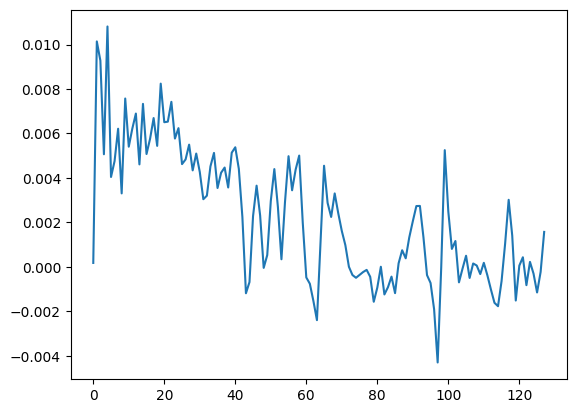

In [5]:
df.iloc[0].plot();

In [6]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [9]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'Datasets/UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x
  
  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
  Ytrain = Ytrain.flatten()

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'Datasets/UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x
  
  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest

In [ ]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

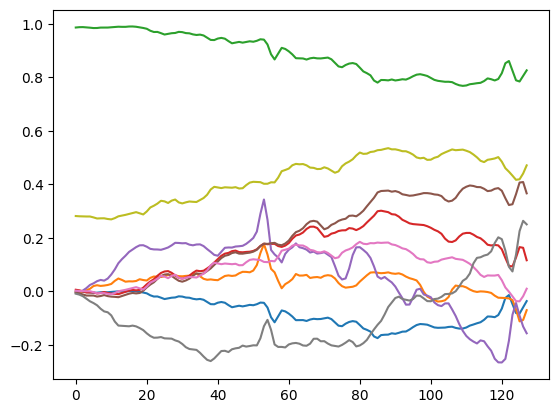

In [11]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [12]:
# ANN
inputs = []
features = []

# make a neural network for each of the D time series
for d in range(D):
  i = Input(shape=(T,))
  x = Dense(32, activation='relu')(i)
  x = Dense(16, activation='relu')(x)
  inputs.append(i)
  features.append(x)

# output of concatenate will be D * (size of individual ANN output)
x = Concatenate()(features)
x = Dense(K)(x)
model = Model(inputs, x)

In [ ]:
tf.keras.utils.plot_model(model)

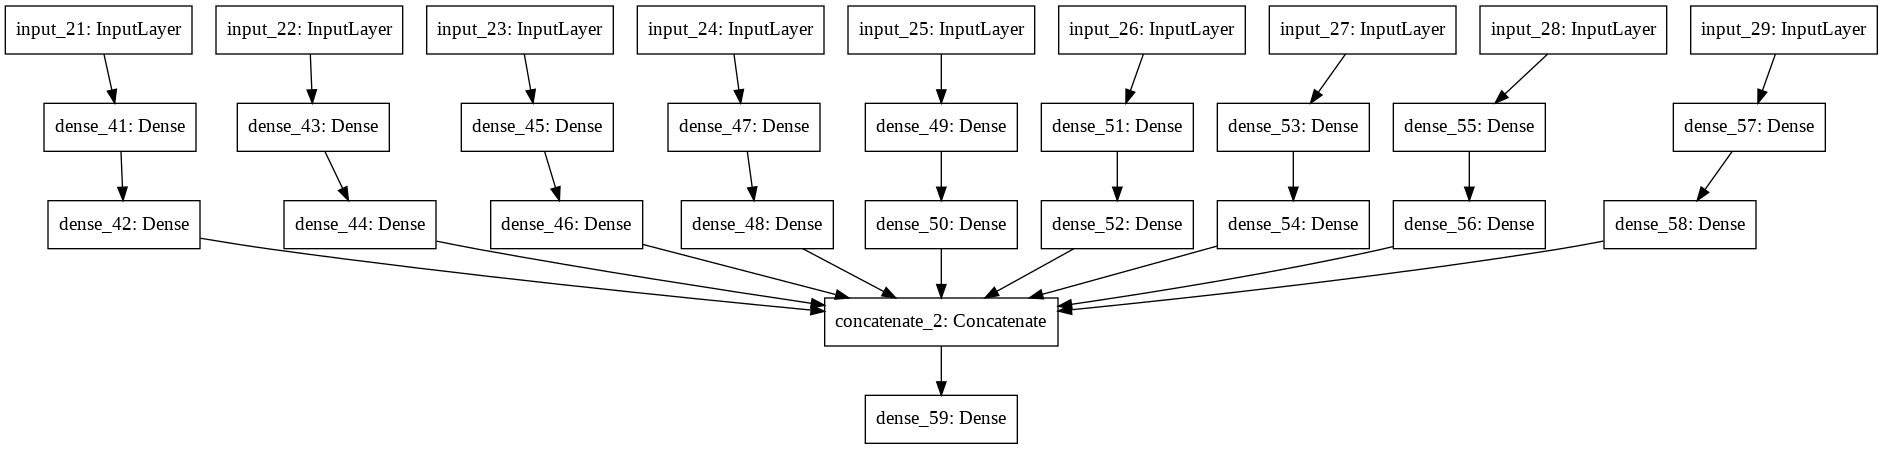

In [14]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True)

In [15]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [16]:
Xtrain_split = []
Xtest_split = []
for d in range(D):
  Xtrain_split.append(Xtrain[:, :, d])
  Xtest_split.append(Xtest[:, :, d])

In [17]:
r = model.fit(
  Xtrain_split,
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=(Xtest_split, Ytest),
)

Epoch 1/15
230/230 [==============================] - 4s 10ms/step - loss: 0.6342 - accuracy: 0.7820 - val_loss: 0.4251 - val_accuracy: 0.8395
Epoch 2/15
230/230 [==============================] - 2s 8ms/step - loss: 0.2300 - accuracy: 0.9185 - val_loss: 0.3326 - val_accuracy: 0.8738
Epoch 3/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1668 - accuracy: 0.9436 - val_loss: 0.3084 - val_accuracy: 0.8823
Epoch 4/15
230/230 [==============================] - 2s 8ms/step - loss: 0.1358 - accuracy: 0.9504 - val_loss: 0.3022 - val_accuracy: 0.8897
Epoch 5/15
230/230 [==============================] - 2s 8ms/step - loss: 0.1183 - accuracy: 0.9589 - val_loss: 0.2596 - val_accuracy: 0.9013
Epoch 6/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1040 - accuracy: 0.9637 - val_loss: 0.2682 - val_accuracy: 0.8918
Epoch 7/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0951 - accuracy: 0.9676 - val_loss: 0.2594 - val_accuracy: 0.9019
Epoch

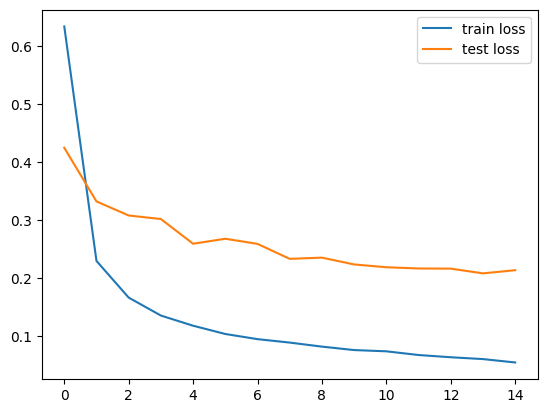

In [18]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

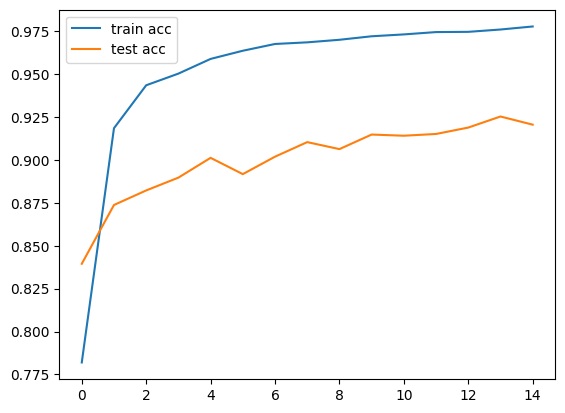

In [19]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [20]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [21]:
# make predictions
Ptest = best_model.predict(Xtest_split)

93/93 [==============================] - 0s 3ms/step


In [22]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9253478113335596

In [25]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'Datasets/UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)
  
  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'Datasets/UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)
  
  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [ ]:
feat_train, feat_test = load_features()

In [27]:
D_feat = feat_train.shape[1]

In [28]:
# Basic ANN
i = Input(shape=(D_feat,))
x = Dense(32, activation='relu')(i)
x = Dense(K)(x)
model = Model(i, x)

In [29]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [30]:
check_point2 = ModelCheckpoint(
    'best_model_basic.h5', monitor='val_accuracy', save_best_only=True)

In [31]:
r = model.fit(
  feat_train,
  Ytrain,
  epochs=15,
  callbacks=[check_point2],
  validation_data=(feat_test, Ytest),
)

Epoch 1/15
230/230 [==============================] - 1s 5ms/step - loss: 0.2914 - accuracy: 0.8979 - val_loss: 0.2112 - val_accuracy: 0.9237
Epoch 2/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1049 - accuracy: 0.9629 - val_loss: 0.1792 - val_accuracy: 0.9301
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0747 - accuracy: 0.9732 - val_loss: 0.1721 - val_accuracy: 0.9342
Epoch 4/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0615 - accuracy: 0.9765 - val_loss: 0.1876 - val_accuracy: 0.9287
Epoch 5/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0520 - accuracy: 0.9827 - val_loss: 0.1763 - val_accuracy: 0.9362
Epoch 6/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0437 - accuracy: 0.9842 - val_loss: 0.1775 - val_accuracy: 0.9379
Epoch 7/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0427 - accuracy: 0.9844 - val_loss: 0.2012 - val_accuracy: 0.9342
Epoch 

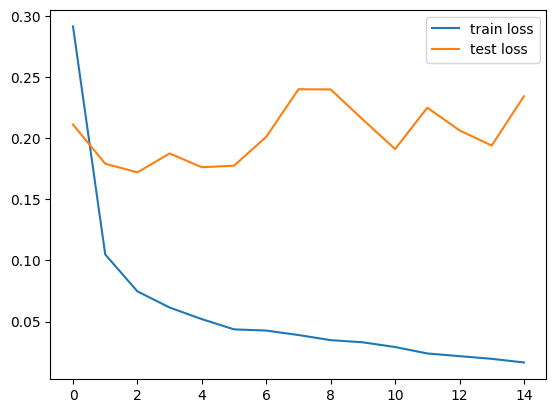

In [32]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

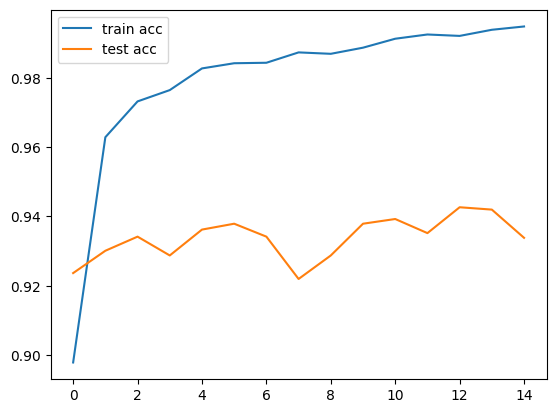

In [33]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [34]:
# load best model
best_model = tf.keras.models.load_model('best_model_basic.h5')

In [35]:
# make predictions
Ptest = best_model.predict(feat_test)

93/93 [==============================] - 0s 1ms/step


In [36]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9426535459789617

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [38]:
model = LogisticRegression(
    solver='liblinear',
)
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

0.9945593035908596

In [39]:
model.score(feat_test, Ytest)

0.9613165931455717

In [40]:
model = SVC()
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

0.9866702937976061

In [41]:
model.score(feat_test, Ytest)

0.9521547336274178

In [42]:
# model = SVC(kernel='linear')
model = LinearSVC()
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

0.9975516866158868

In [43]:
model.score(feat_test, Ytest)

0.9626739056667798

In [44]:
model = RandomForestClassifier()
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

1.0

In [45]:
model.score(feat_test, Ytest)

0.9307770614183916

In [46]:
# Combined Model
inputs = []
features = []

# make a neural network for each of the D time series
for d in range(D):
  i = Input(shape=(T,))
  x = Dense(32, activation='relu')(i)
  x = Dense(16, activation='relu')(x)
  inputs.append(i)
  features.append(x)

i2 = Input(shape=(D_feat,))
x2 = Dense(32, activation='relu')(i2)

# output of concatenate will be D * (size of individual ANN output)
x = Concatenate()(features + [x2])
x = Dense(K)(x)
model = Model(inputs + [i2], x)

In [47]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [48]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

In [49]:
r = model.fit(
  Xtrain_split + [feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point3],
  validation_data=(Xtest_split + [feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 3s 12ms/step - loss: 0.2874 - accuracy: 0.9027 - val_loss: 0.2161 - val_accuracy: 0.9267
Epoch 2/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0855 - accuracy: 0.9727 - val_loss: 0.1725 - val_accuracy: 0.9365
Epoch 3/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0639 - accuracy: 0.9761 - val_loss: 0.1643 - val_accuracy: 0.9454
Epoch 4/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0542 - accuracy: 0.9788 - val_loss: 0.1842 - val_accuracy: 0.9423
Epoch 5/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0484 - accuracy: 0.9816 - val_loss: 0.1438 - val_accuracy: 0.9515
Epoch 6/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0390 - accuracy: 0.9861 - val_loss: 0.1577 - val_accuracy: 0.9508
Epoch 7/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0386 - accuracy: 0.9867 - val_loss: 0.1662 - val_accuracy: 0.9515
Epoch

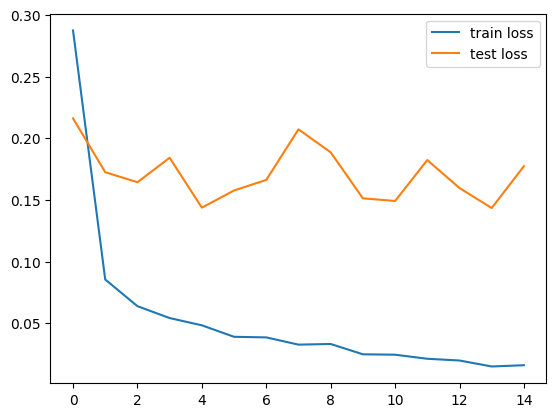

In [50]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

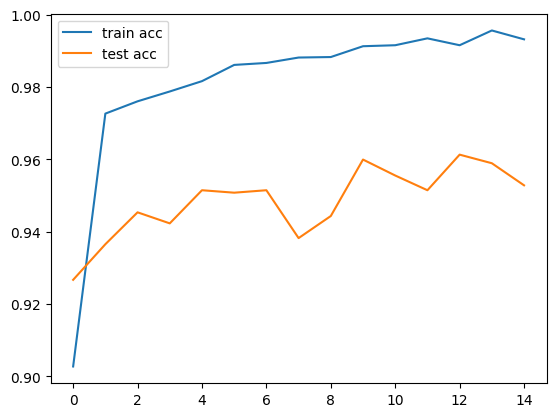

In [51]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [52]:
# load best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [53]:
# make predictions
Ptest = best_model.predict(Xtest_split + [feat_test])

93/93 [==============================] - 0s 3ms/step


In [54]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9613165931455717